In [48]:
# importing cell
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import odeint

# Data Generation

## Lorenz system

The first dynamical system we will explore is the renowned Lorenz system of differential equations:

$$
\begin{cases}
\dot{x} = \sigma(y-x) \\ 
\dot{y} = x(\rho - z) - y \\
\dot{z} = xy - \beta z
\end{cases}
$$

Where the parameters $\sigma, \rho, \beta$ are assumed to be positive. We will set their value to 

$$
\begin{cases}
\sigma = 10 \\ 
\rho = 28 \\ 
\beta = \frac{8}{3}
\end{cases}
$$

These are the values used originally by Lorenz, and they spawn chaotic solutions that will almost always (depending on the initial condition) tend to an invariant set, the Lorenz attractor:

In [49]:
def lorenz(r,t,sigma,rho,beta):
    """
    Function to implement the Lorenz system of differential equation. Takes in two arguments:
    r : array of 3 floats representing (x,y,z)
    t : float for time value; unused by the Lorenz system but here for scipy compatibility.
    sigma :
    rho :
    beta : parameters (float)
    Returns:
    drdt : velocity vector
    """
    x,y,z = r
    return np.array([sigma*(y-x),x*(rho-z) - y,x*y - beta*z])

sigma = 10
rho = 28
beta = 8/3

r0 = np.ones(3)

N = 10000
T = 100

t = np.linspace(0,T,N)


We will use `scipy`'s `odeint` routine, which solves systems of ordinary differential equations using Isoda from FORTRAN's library.

In [50]:
r,info = odeint(lorenz,r0,t,args=(sigma,rho,beta),full_output=True) # output is like (N,3)

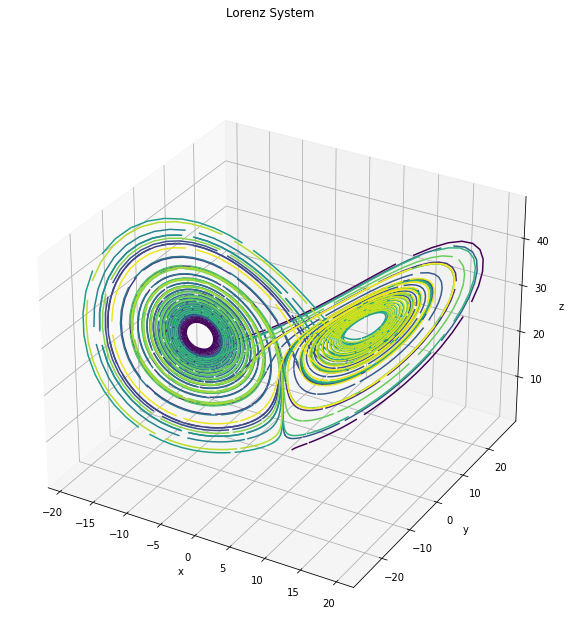

In [51]:
fig = plt.figure(figsize=[10,10])
fig.suptitle("Lorenz System")
ax = fig.add_subplot(projection='3d')
ax.set(xlabel='x',ylabel='y',zlabel='z')
j = 10

viridis = cm.get_cmap('viridis', N).colors

for i in range(0,N,j):
    ax.plot(r[i:i+j,0],r[i:i+j,1],r[i:i+j,2],color=viridis[i])


In [52]:
! mkdir -p data
np.save("./data/lorenz_r",r)
np.save("./data/lorenz_t",t)

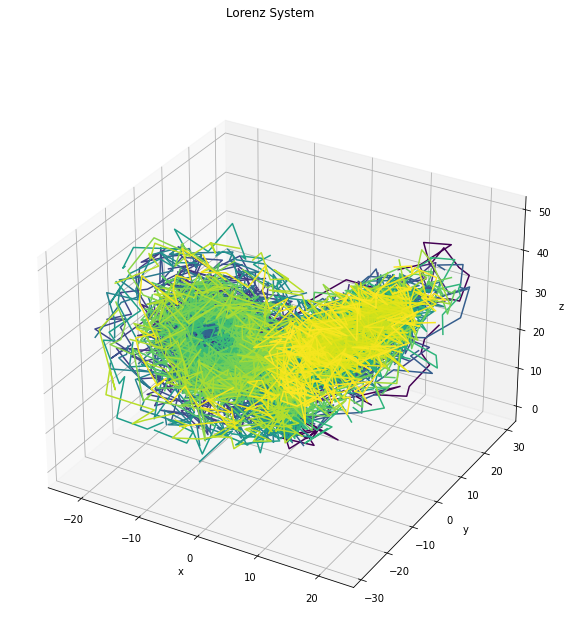

In [58]:
# NOISY SYSTEM

noise_scale = 2
r_noisy = r + np.random.normal(0,noise_scale,size=r.shape)

fig = plt.figure(figsize=[10,10])
fig.suptitle("Lorenz System")
ax = fig.add_subplot(projection='3d')
ax.set(xlabel='x',ylabel='y',zlabel='z')
j = 10

viridis = cm.get_cmap('viridis', N).colors

for i in range(0,N,j):
    ax.plot(r_noisy[i:i+j,0],r_noisy[i:i+j,1],r_noisy[i:i+j,2],color=viridis[i])

In [59]:
! mkdir -p data
np.save("./data/lorenz_r_noisy",r)

## "Adiabatic" transforming system

Now imagine we have a differential equations system whose parameters $\boldsymbol{\Lambda} = \boldsymbol{\Lambda}(t)$ slowly evolve through time. Let's also suppose that these parameters start out in such a way that the resulting system is a Lorenz system, and the final one is a Rössler system:

$$
\begin{bmatrix}
\frac{\partial x}{\partial t} \\
\frac{\partial y}{\partial t} \\
\frac{\partial z}{\partial t}
\end{bmatrix}
=
\boldsymbol{\Lambda}(t)
\begin{bmatrix}
1 \\
x \\
y \\
z \\
xy \\
yz \\
zx
\end{bmatrix}
=

\begin{bmatrix}
\lambda_{x,1} (t) & \lambda_{x,x} (t) & \lambda_{x,y} (t) & \lambda_{x,z} (t) & \lambda_{x,xy}(t) & \lambda_{x,yz}(t) & \lambda_{x,zx}(t) \\
\lambda_{y,1} (t) &\lambda_{y,x} (t) & \lambda_{y,y} (t) & \lambda_{y,z} (t) & \lambda_{y,xy}(t) & \lambda_{y,yz}(t) & \lambda_{y,zx}(t)\\
\lambda_{z,1} (t) &\lambda_{z,x} (t) & \lambda_{z,y} (t) & \lambda_{z,z} (t) &  \lambda_{z,xy}(t) & \lambda_{z,yz}(t) & \lambda_{z,zx}(t) 
\end{bmatrix}

\begin{bmatrix}
1 \\
x \\
y \\
z \\
xy \\
yz \\
zx
\end{bmatrix}
$$

with 

$$
\boldsymbol{\Lambda}(0) = 
\begin{bmatrix}
0&-\sigma  & \sigma  & 0 & 0 & 0 & 0 \\
0&\rho & -1  & -\rho & 0 & 0 & 0\\
0&0 & 0 & -\beta & 1 & 0 & 0 
\end{bmatrix}

$$

and, since the Rössler is defined as 

$$

\begin{cases}
\dot{x} = -y -z \\ 
\dot{y} = x+ay \\
\dot{z} = b + z(x-c)
\end{cases}

$$

The parametrization at time $T$ will be

$$
\boldsymbol{\Lambda}(T) = 
\begin{bmatrix}
0&0  & -1  & -1 & 0 & 0 & 0 \\
0&1 & a  & 0 & 0 & 0 & 0\\
b&0 & 0 & -c & 0 & 0 & 1 
\end{bmatrix}
$$

Finally, we let this change be linear with time, i.e.:

$$
\boldsymbol{\Lambda}(t) = \boldsymbol{\Lambda}(0) + \frac{\boldsymbol{\Lambda}(T) - \boldsymbol{\Lambda}(0)}{T} t
$$


The goal is to later feed time windowed subsets of this system to the SINDy algorithm and evaluate the tradeoff on the uncertainty between a large and a small time window.

In [29]:
def lt(t,l0,lT,T):
    return (l0 + t*(lT-l0)/T)

# now we define the initial parametrization corresponding to the lorenz system

sigma = 10
rho = 28
beta = 8/3

l0 = np.array([
    [0.,-sigma,sigma,0.,0.,0.,0.],
    [0.,rho,-1.,-rho,0.,0.,0.],
    [0.,0.,0.,-beta,1.,0.,0.]
])

# and the final parametrization

a = 0.1
b = 0.1
c = 14.

lT = np.array([
    [0.,0.,-1.,-1.,0.,0.,0.],
    [0.,1.,a,0.,0.,0.,0.],
    [b,0.,0.,-c,0.,0.,1.]
])

Tad = T

li=np.expand_dims(l0,axis=0)

for ti in t:
    li = np.concatenate(    (li,np.expand_dims(lt(ti,l0,lT,Tad),axis=0)),axis=0   )



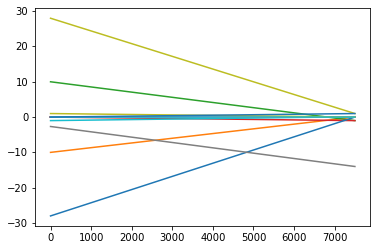

In [30]:
li2 = li.reshape(li.shape[0],-1)

fig,ax=plt.subplots()
for i in range(li2.shape[1]):
    ax.plot(li2[:,i])

plt.show()

In [31]:
def linear_adiabatic_system(r,t,l0,lT,T):
    """
    Function to implement the adiabatic-transforming system of differential equation.  
    Arguments:
    r : array of 3 floats representing (x,y,z)
    t : float for time value
    l0 : np.array() shaped like (3,7) representing the initial parametrization
    lT : np.array() shaped like (3,7) representing the final parametrization
    T : transformation time duration
    Returns:
    drdt : velocity vector
    """
    
    vec = np.array([1.,r[0],r[1],r[2],r[0]*r[1],r[1]*r[2],r[2]*r[0]])

    return (lt(t,l0,lT,T) @ vec)

In [32]:
# COMPLETELY BROKEN

r0 = np.ones(3)

N = 100000
T = 1000

Tad = T*10

t = np.linspace(0,T,N)

r,info = odeint(linear_adiabatic_system,r0,t,args=(l0,lT,Tad),full_output=1) # output is like (N,3)

/home/zano/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [33]:
r

array([[1.        , 1.        , 1.        ],
       [0.9995921 , 0.99231898, 0.98351013],
       [0.99870853, 0.9890657 , 0.96739374],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

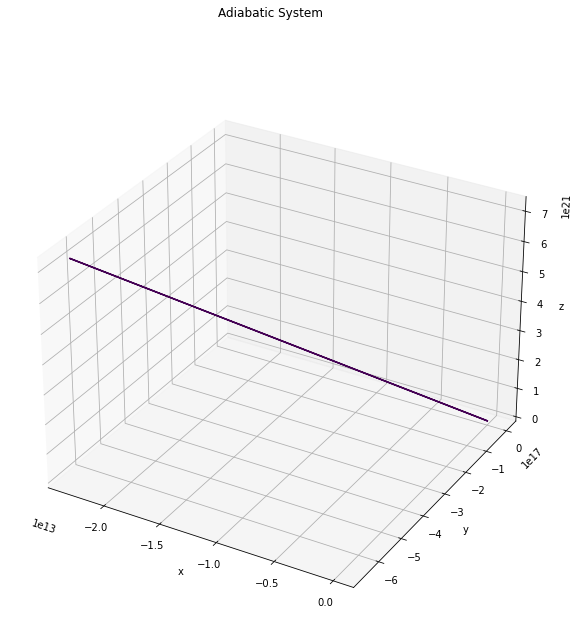

In [34]:
fig = plt.figure(figsize=[10,10])
fig.suptitle("Adiabatic System")
ax = fig.add_subplot(projection='3d')
ax.set(xlabel='x',ylabel='y',zlabel='z')
j = 10

viridis = cm.get_cmap('viridis', N).colors

for i in range(0,N,j):
    ax.plot(r[i:i+j,0],r[i:i+j,1],r[i:i+j,2],color=viridis[i])